In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs


def error_rate(errors, errloc, sequence):
    dep = len(sequence)
    err = len(errors)
    errors=errors.reshape(1,-1)

    result = np.stack((np.arange(2**err),) * err, axis=1)

    divide = np.stack((2**np.arange(err)[::-1],)*2**err, axis=0) 

    result=result//divide%2      # Creates binary matrix

    result=result[np.all(np.dot(result,errloc)%2==sequence, axis=1)] #find error combination that agrees with sequence
    return np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))

# QSample

In [3]:
ghz = qs.Circuit([ {"init": {0,1,2,3,4}},
                   {"H": {0}},
                   {"CNOT": {(0,1)}},
                   {"CNOT": {(1,2)}},
                   {"CNOT": {(2,3)}},
                   {"CNOT": {(3,4)}},
                   {"CNOT": {(0,4)}},
                   {"measure": {4}}   ])

# Define protocol for 1 round of repetition

def logErr(msmt_list):
    return msmt_list[-1] == 1 # If True transition to FAIL

functions = {'logErr': logErr}

ghz1 = qs.Protocol(check_functions=functions, fault_tolerant=False)

ghz1.add_node('ghz', circuit=ghz) # Add node with corresponding circuit
ghz1.add_edge('START', 'ghz', check='True') # Transition START -> first circuit node always True
ghz1.add_edge('ghz', 'FAIL', check='logErr(ghz)')

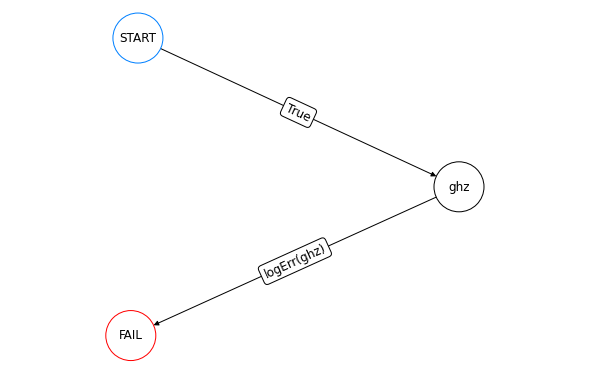

In [4]:
ghz1.draw(figsize=(8,5))

In [5]:
err_model = qs.noise.E1
q = [1e-5, 1e-3, 1e-1, 0.5]
err_params = {'q': q}

In [6]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=ghz1, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [7]:
txt = "H 0 \n DEPOLARIZE1({}) 0 \n CNOT 0 1\n DEPOLARIZE2({}) 0 1\n CNOT 1 2\n DEPOLARIZE2({}) 1 2\n CNOT 2 3\n DEPOLARIZE2({}) 2 3\n CNOT 3 4\n DEPOLARIZE2({}) 3 4\n CNOT 0 4\n DEPOLARIZE2({}) 0 4\nM 4\n DETECTOR rec[-1]"
i = 0.1
circuit = stim.Circuit(txt.format(i, i, i, i, i, i))

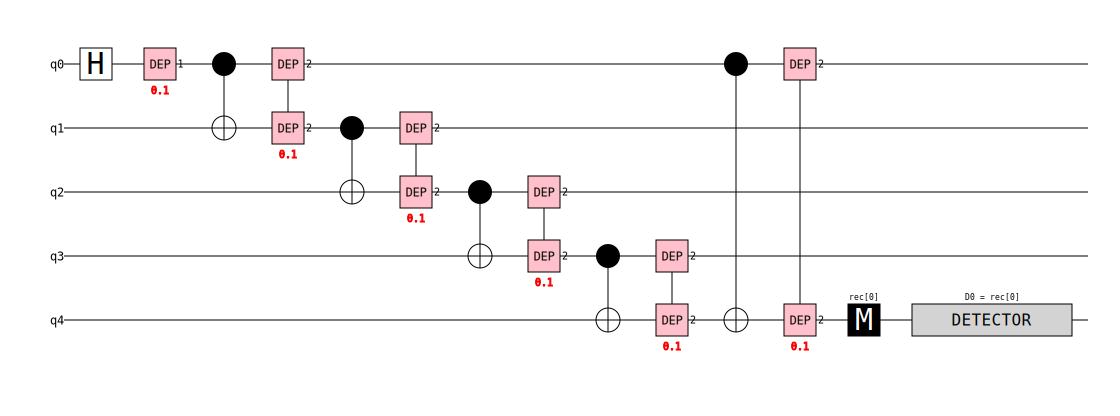

In [8]:
circuit.diagram('timeline-svg')

In [16]:
errors = []
begin = time.time()
for i in q:
    circuit = stim.Circuit(txt.format(i, i, i, i, i, i))
    dem = circuit.detector_error_model()
    errors.append(dem2matrices(repr(dem), 1)[0][0])
end = time.time()
stim_time = end-begin

# Comparison

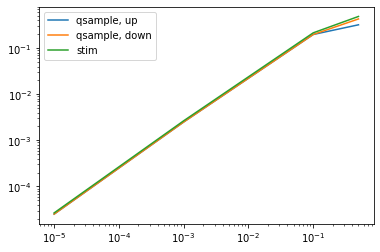

In [14]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, errors, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [17]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))

QSample time: 0.346s
STIM time: 0.000697s


In [18]:
458.95-232.36

226.58999999999997

In [19]:
250+136+30+20+15+820+136+30+20+15+350+820-980-980

682